# Assignment 2 - Machine Learning Pipeline

In [49]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

In [50]:
# Autoreload file containing helper functions
%load_ext autoreload
%autoreload 2
import data_processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [51]:
# Load data and set index
df = data_processing.load_data('data/credit-data.csv', 'PersonID')

## Data Exploration

In [52]:
# Observe data structure using "head" function
df.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [53]:
# Use "describe" to get broad understanding of range of values for each variable
df.describe() 

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000000,41016.000000,41016.00000,41016.000000,41016.000000,41016.000000,41016.000000,3.304200e+04,41016.000000,41016.000000,41016.000000,41016.000000,39979.000000
mean,115800.154598,0.161400,6.37587,51.683489,60623.824166,0.589233,331.458137,6.578996e+03,8.403477,0.419592,1.008801,0.371587,0.773231
std,28112.723511,0.367904,221.61895,14.746880,11.984357,5.205628,1296.109695,1.344683e+04,5.207324,5.190382,1.153826,5.169641,1.121269
min,22.000000,0.000000,0.00000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106539.750000,0.000000,0.03431,41.000000,60618.000000,0.000000,0.176375,3.333000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119901.500000,0.000000,0.18973,51.000000,60625.000000,0.000000,0.369736,5.250000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,134698.250000,0.000000,0.66716,62.000000,60629.000000,0.000000,0.866471,8.055750e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.00000,109.000000,60644.000000,98.000000,106885.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


### Commentary
Based on the describe function, we can see that many of the financial indicators have high max values and relatively large standard deviations, which can be an indication of either outlier values or "long-tail" values that are true reflections of spread in the data. This is an issue to be investigated further.

In the case of the "Number of Times Late" columns, the max values of 98 do have particular meaning that is not a reflection of data skew. According to the "Give Me Some Credit" discussion boards, values of 96, 97, and 98 mean that respondents refused to say or responded "other". While this is a response that has meaning, for the purposes of this analysis I will exclude records with those values.

https://www.kaggle.com/c/GiveMeSomeCredit/discussion/867

In [54]:
# Filter out all values greater than or equal to 96 in the late payment fields
df = df[~((df['NumberOfTimes90DaysLate']>=96) | (df['NumberOfTime60-89DaysPastDueNotWorse']>=96) 
          | (df['NumberOfTime30-59DaysPastDueNotWorse']>=96))]

In [55]:
# Define continuous vs discrete variables
continuous_cols = ['RevolvingUtilizationOfUnsecuredLines','age', 
                   'DebtRatio','MonthlyIncome']

discrete_cols = ['SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse',
                    'NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate', 
                    'NumberRealEstateLoansOrLines',
                    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


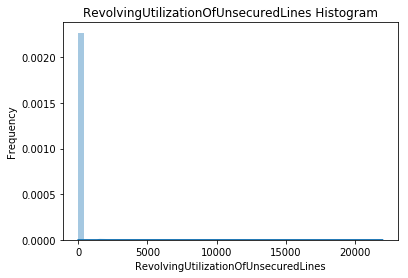

None


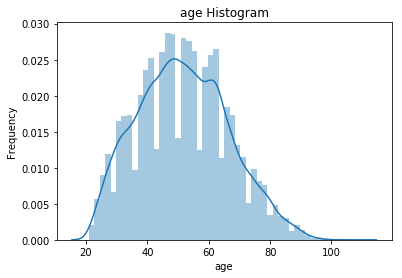

None


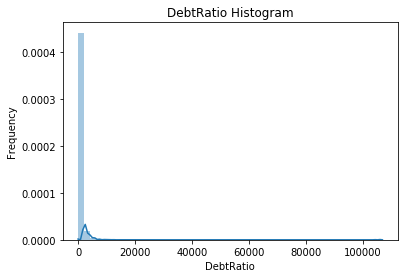

None


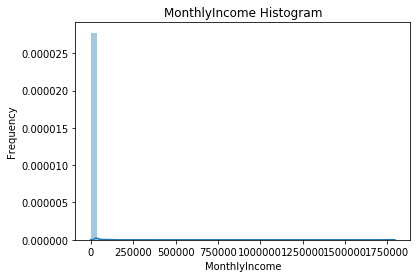

None


In [56]:
# Create histograms for continuous variables
for col in continuous_cols:
    print(data_processing.make_histogram(df, col))

### Commentary

The age variable shows an approximately normal distribution, with the volume of respondents who are 60+ dropping sharply. This is expected based on what we know about age distribution of the population.

The financial variables all have a cluster/peak in the lowest historam bin, but the distribution has a long, right-skewed tail. Upon closer investigation of the values in the tail, it appears that they reflect true variation in the population rather than miscodings or other outlier values. Therefore I will not correct these values.

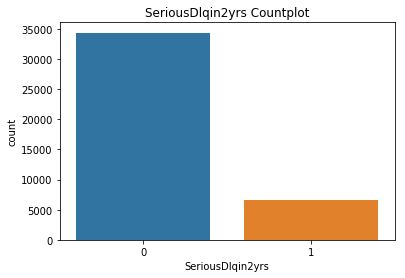

None


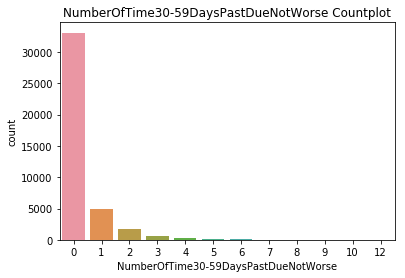

None


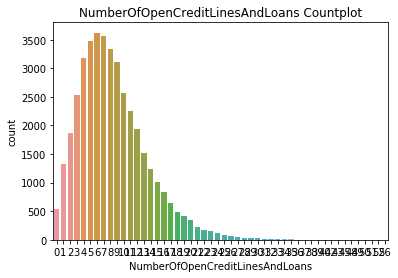

None


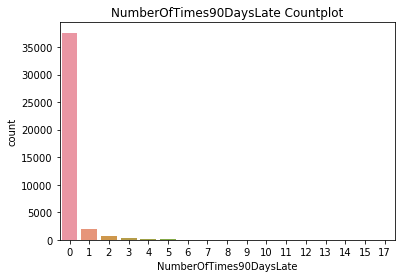

None


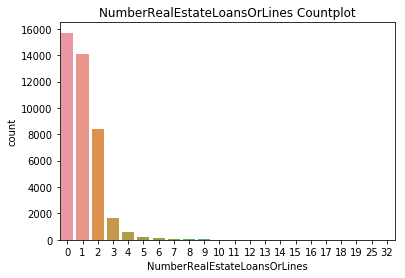

None


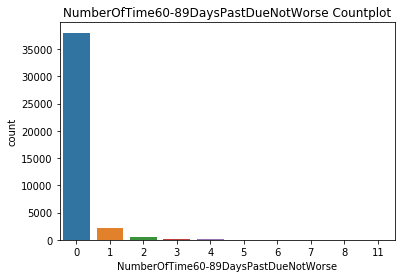

None


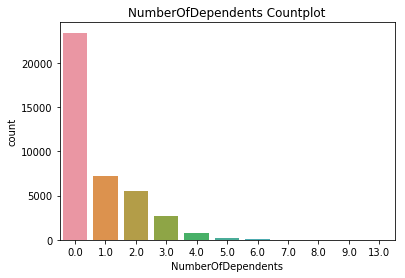

None


In [57]:
# Create countcharts for discrete variables
for col in discrete_cols:
    print(data_processing.make_countchart(df, col))

### Commentary
The pattern looks similar in the case of the discrete variables. All of the distributions have a long, right-skewed tail. The "Number of Open Credit Lines and Loans" chart appears more normally distributed, indicating that most respondents are likely to have a few credit lines and loans at any given time. When we consider that this can include home/auto loans, student loans, and credit cards, this distribution makes some intuitive sense.

The other financial variables all have their highest frequency at 0, again with a long tail. If we consider the "Number of Times Past Due" variables, it again makes intuitive sense that most people do not experience a late payment in a given year, though there are a small number of individuals in a pattern of financial distress who experience a high number.

The Serious Delinquency in the Previous 2 Years variable is what we are interested in predicting. This is a binary categorical variable, with 0 indicationg no delinquency and 1 indicating delinquency. 6,525 respondents out of 40,902 (~16%) experience serious delinquency.

In [58]:
# Check correlation between dataset variables
corr = data_processing.check_correlations(df)
corr

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,1.000000,-0.622758,0.004455,0.106861,-0.021581,-0.213398,0.006237,0.019226,0.018574,-0.220860,0.002052,-0.193127,-0.032001
SeriousDlqin2yrs,-0.622758,1.000000,-0.004490,-0.170384,-0.044811,0.346318,-0.012319,-0.031857,-0.032004,0.354461,-0.006235,0.317781,0.067891
RevolvingUtilizationOfUnsecuredLines,0.004455,-0.004490,1.000000,-0.008100,0.006015,-0.004671,0.022235,0.005820,-0.014752,-0.003328,0.004709,-0.001678,0.005322
age,0.106861,-0.170384,-0.008100,1.000000,0.005392,-0.078427,0.038173,0.047631,0.156008,-0.099460,0.046713,-0.082306,-0.212778
zipcode,-0.021581,-0.044811,0.006015,0.005392,1.000000,-0.016506,0.002092,-0.004932,-0.009244,-0.013289,0.003155,-0.016763,-0.001875
NumberOfTime30-59DaysPastDueNotWorse,-0.213398,0.346318,-0.004671,-0.078427,-0.016506,1.000000,0.008705,-0.007851,0.085194,0.235397,0.049158,0.332271,0.072264
DebtRatio,0.006237,-0.012319,0.022235,0.038173,0.002092,0.008705,1.000000,-0.023019,0.081976,-0.013956,0.177456,-0.002226,-0.070883
MonthlyIncome,0.019226,-0.031857,0.005820,0.047631,-0.004932,-0.007851,-0.023019,1.000000,0.106389,-0.027220,0.126888,-0.014421,0.060371
NumberOfOpenCreditLinesAndLoans,0.018574,-0.032004,-0.014752,0.156008,-0.009244,0.085194,0.081976,0.106389,1.000000,-0.110482,0.440916,-0.028622,0.058812
NumberOfTimes90DaysLate,-0.220860,0.354461,-0.003328,-0.099460,-0.013289,0.235397,-0.013956,-0.027220,-0.110482,1.000000,-0.071127,0.320829,0.030887


In [59]:
# Check for high correlation with predictor variable
high_corr_threshold = 0.7
high_corr_vars = data_processing.find_high_corr(corr, high_corr_threshold, 'SeriousDlqin2yrs')
high_corr_vars

Index(['SeriousDlqin2yrs'], dtype='object')

### Commentary
Based on observation of the chart above, most variables are not significantly correlated with either our predictor variable (SeriousDlqin2yrs) or other features. The exception is again the "Number of Time Past Due" variables. They have a greater degree of correlation both with each other and with Serious Delinquency. This gives us a general indication that those who experience short-term delinquency are more likely to experience serious delinquency, which makes intuitive sense. Since the level of correlation is still relatively low (below 0.4), I will not exclude features based on this result. 

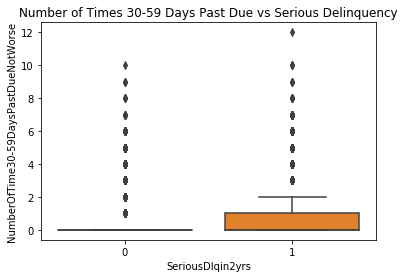

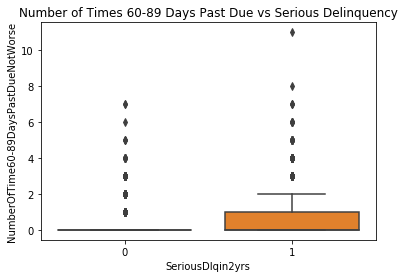

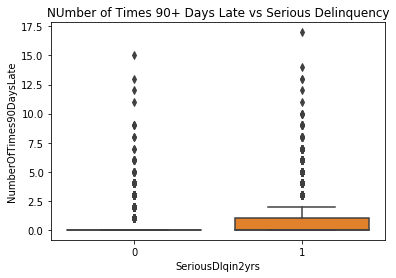

In [60]:
# Chart short-term delinquencies against serious delinquency
sns.boxplot('SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse', data = df)
plt.title('Number of Times 30-59 Days Past Due vs Serious Delinquency')
plt.show()
sns.boxplot('SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse', data = df)
plt.title('Number of Times 60-89 Days Past Due vs Serious Delinquency')
plt.show()
sns.boxplot('SeriousDlqin2yrs', 'NumberOfTimes90DaysLate', data = df)
plt.title('NUmber of Times 90+ Days Late vs Serious Delinquency')
plt.show()

### Commentary
As expected, we see that those who fell into serious delinquency had a greater number of short-term delinquencies.

## Data Processing/Cleaning

### Commentary
We observed above that the distribution of financial variables is characterized by a long-tail. This means that the mean of each variable will be artifically increased by the outlier variables as compared with the median. Therefore, I will use the median value to fill null values rather than the mean, as it is more likely to reflect a "typical" respondent.

In [61]:
# Fill null values with median value (specified in data_processing.py)
model_df = data_processing.fill_nulls(df)

In [62]:
# Observe distribution of "cleaned" dataset
model_df.describe()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,40902.000000,40902.000000,40902.000000,40902.000000,40902.000000,40902.000000,40902.000000,4.090200e+04,40902.000000,40902.000000,40902.000000,40902.000000,40902.000000
mean,115874.117916,0.159528,6.390853,51.727960,60623.824067,0.317833,332.358069,6.330815e+03,8.426874,0.147719,1.011613,0.099579,0.754926
std,28024.187827,0.366172,221.927403,14.725605,11.988848,0.819617,1297.801022,1.209591e+04,5.195653,0.648396,1.154201,0.422799,1.114235
min,22.000000,0.000000,0.000000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106588.250000,0.000000,0.034133,41.000000,60618.000000,0.000000,0.177775,3.800000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119921.500000,0.000000,0.187554,51.000000,60625.000000,0.000000,0.370656,5.264000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,134718.250000,0.000000,0.661568,62.000000,60629.000000,0.000000,0.868662,7.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.000000,109.000000,60644.000000,12.000000,106885.000000,1.794060e+06,56.000000,17.000000,32.000000,11.000000,13.000000


## Generate Features/Predictors

In [63]:
# Discretize the age variable into 10 ranges
model_df['age_range'] = data_processing.continuous_to_cat(model_df, 'age')

In [64]:
# Make Number of Open Credit Lines a dummy variable
model_df = data_processing.cat_to_dummy(model_df, 'NumberOfOpenCreditLinesAndLoans')

In [65]:
# Define feature vs predictor variables
predictor = 'SeriousDlqin2yrs'

max_features = ['RevolvingUtilizationOfUnsecuredLines',
       'age', 'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age_range', 'NumberOfOpenCreditLinesAndLoans_0',
       'NumberOfOpenCreditLinesAndLoans_1',
       'NumberOfOpenCreditLinesAndLoans_2',
       'NumberOfOpenCreditLinesAndLoans_3',
       'NumberOfOpenCreditLinesAndLoans_4',
       'NumberOfOpenCreditLinesAndLoans_5',
       'NumberOfOpenCreditLinesAndLoans_6',
       'NumberOfOpenCreditLinesAndLoans_7',
       'NumberOfOpenCreditLinesAndLoans_8',
       'NumberOfOpenCreditLinesAndLoans_9',
       'NumberOfOpenCreditLinesAndLoans_10',
       'NumberOfOpenCreditLinesAndLoans_11',
       'NumberOfOpenCreditLinesAndLoans_12',
       'NumberOfOpenCreditLinesAndLoans_13',
       'NumberOfOpenCreditLinesAndLoans_14',
       'NumberOfOpenCreditLinesAndLoans_15',
       'NumberOfOpenCreditLinesAndLoans_16',
       'NumberOfOpenCreditLinesAndLoans_17',
       'NumberOfOpenCreditLinesAndLoans_18',
       'NumberOfOpenCreditLinesAndLoans_19',
       'NumberOfOpenCreditLinesAndLoans_20',
       'NumberOfOpenCreditLinesAndLoans_21',
       'NumberOfOpenCreditLinesAndLoans_22',
       'NumberOfOpenCreditLinesAndLoans_23',
       'NumberOfOpenCreditLinesAndLoans_24',
       'NumberOfOpenCreditLinesAndLoans_25',
       'NumberOfOpenCreditLinesAndLoans_26',
       'NumberOfOpenCreditLinesAndLoans_27',
       'NumberOfOpenCreditLinesAndLoans_28',
       'NumberOfOpenCreditLinesAndLoans_29',
       'NumberOfOpenCreditLinesAndLoans_30',
       'NumberOfOpenCreditLinesAndLoans_31',
       'NumberOfOpenCreditLinesAndLoans_32',
       'NumberOfOpenCreditLinesAndLoans_33',
       'NumberOfOpenCreditLinesAndLoans_34',
       'NumberOfOpenCreditLinesAndLoans_35',
       'NumberOfOpenCreditLinesAndLoans_36',
       'NumberOfOpenCreditLinesAndLoans_37',
       'NumberOfOpenCreditLinesAndLoans_38',
       'NumberOfOpenCreditLinesAndLoans_39',
       'NumberOfOpenCreditLinesAndLoans_40',
       'NumberOfOpenCreditLinesAndLoans_42',
       'NumberOfOpenCreditLinesAndLoans_43',
       'NumberOfOpenCreditLinesAndLoans_45',
       'NumberOfOpenCreditLinesAndLoans_48',
       'NumberOfOpenCreditLinesAndLoans_49',
       'NumberOfOpenCreditLinesAndLoans_50',
       'NumberOfOpenCreditLinesAndLoans_51',
       'NumberOfOpenCreditLinesAndLoans_52',
       'NumberOfOpenCreditLinesAndLoans_56']

## Build Classifier

In [66]:
# Generate feature vs predictor dataframes
X, Y = data_processing.x_y_generator(model_df, max_features, predictor)

In [67]:
# Build Train/Test dataframes
test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [68]:
# Build and fit k-nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors=6, metric='manhattan', weights = 'distance')
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

## Evaluate Classifier

In [69]:
# Evaluate accuracy on test set
data_processing.check_accuracy(y_test, y_predict)

0.8286779536703136

In [70]:
# Test set confusion matrix
data_processing.confusion_matrix(y_test, y_predict)

array([[13393,   350],
       [ 2453,   165]])

### Commentary 
After testing a variety of model configurations, the combination of a small number of neighbors (6) and the Manhattan distance metric weighted by distance produced the best result. While other models had a higher accuracy rate, this model did the best on correctly categorizing serious delinquencies. This model still only correctly predicts ~30% of the serious delinquencies (235 out of 797) in the test set. It falsely categorizes ~70% of true delinquences as non-delinqencies, and falsely categorizes ~15% of true non-delinquencies as delinquencies.

## Check on Full Dataset

In [71]:
full_pred = knn.predict(X)

In [72]:
data_processing.check_accuracy(Y, full_pred)

0.931445895066256

In [73]:
data_processing.confusion_matrix(Y, full_pred)

array([[34027,   350],
       [ 2454,  4071]])

### Commentary
The accuracy and predictive power is better when we test on the full dataset, but of this is likely because the full dataset includes the data used to train the model.